# Autoencoder Warmup on MNIST

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
import tensorflow_datasets as tfds

## Lets do simple classification as a warmup

In [3]:
ds = tfds.load('mnist', split="train", shuffle_files=True)

In [68]:
train, test = tfds.load('mnist', split=['train', 'test'], 
                        shuffle_files=True, as_supervised=True)

(28, 28, 1)
tf.Tensor(4, shape=(), dtype=int64)


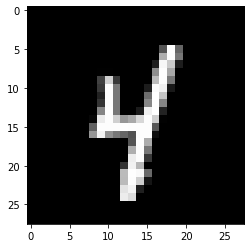

In [69]:
for example in train.take(1):
    print(example[0].shape)
    print(example[1])
    plt.imshow(example[0], cmap="gray")

In [70]:
def normalize_img(image, label):
    return tf.cast(image, tf.float32) / 255., label
train = train.map(normalize_img)
#train = train.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train = train.batch(128).prefetch(tf.data.experimental.AUTOTUNE)


In [71]:
test = test.map(normalize_img).batch(1)

In [8]:
classifier = keras.models.Sequential([
    keras.layers.Flatten(input_shape = (28,28,1)),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(10, activation="softmax"),
])


In [9]:
classifier.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(lr=1e-3), metrics=["accuracy"])

In [10]:
history = classifier.fit(train, epochs=6)

Epoch 1/6
469/469 [==============================] - 8s 17ms/step - loss: 2.1538 - accuracy: 0.2851
Epoch 2/6
469/469 [==============================] - 5s 10ms/step - loss: 1.8378 - accuracy: 0.5864
Epoch 3/6
469/469 [==============================] - 5s 10ms/step - loss: 1.5643 - accuracy: 0.6952
Epoch 4/6
469/469 [==============================] - 5s 10ms/step - loss: 1.3322 - accuracy: 0.7435
Epoch 5/6
469/469 [==============================] - 5s 10ms/step - loss: 1.1506 - accuracy: 0.7734
Epoch 6/6
469/469 [==============================] - 5s 10ms/step - loss: 1.0132 - accuracy: 0.7933


In [11]:
classifier.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Adam(lr=1e-3), metrics=["accuracy"])

In [12]:
history = classifier.fit(train, epochs=6)

Epoch 1/6
469/469 [==============================] - 5s 10ms/step - loss: 0.2891 - accuracy: 0.9188
Epoch 2/6
469/469 [==============================] - 5s 10ms/step - loss: 0.1494 - accuracy: 0.9574
Epoch 3/6
469/469 [==============================] - 5s 10ms/step - loss: 0.1066 - accuracy: 0.9697
Epoch 4/6
469/469 [==============================] - 5s 10ms/step - loss: 0.0820 - accuracy: 0.9770
Epoch 5/6
469/469 [==============================] - 5s 10ms/step - loss: 0.0656 - accuracy: 0.9819
Epoch 6/6
469/469 [==============================] - 5s 10ms/step - loss: 0.0538 - accuracy: 0.9857


### We get significantly higher accuracy using Adam, on the full dataset

# Autoencoder

In [13]:
encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(28,28,1)),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
])
decoder = keras.models.Sequential([
    keras.layers.Dense(128, input_shape=[100], activation="relu"),
    keras.layers.Dense(28*28, activation='relu'),
    keras.layers.Reshape((28,28,1))
])

ae = keras.models.Sequential([encoder, decoder])

In [14]:
ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(1e-3))

In [72]:
def set_y_as_x(image, label):
    return image, image
train_no_labels = train.map(set_y_as_x)

In [16]:
ae.fit(train_no_labels, epochs=6)

Epoch 1/6
469/469 [==============================] - 6s 13ms/step - loss: 0.2857
Epoch 2/6
469/469 [==============================] - 6s 14ms/step - loss: 0.2336
Epoch 3/6
469/469 [==============================] - 6s 13ms/step - loss: 0.2128
Epoch 4/6
469/469 [==============================] - 6s 14ms/step - loss: 0.2269
Epoch 5/6
469/469 [==============================] - 6s 13ms/step - loss: 0.2048
Epoch 6/6
469/469 [==============================] - 6s 14ms/step - loss: 0.2064


## Visualize some results

In [17]:
for img_index, example in enumerate(test.take(5)):
    print(example[0].shape)

(1, 28, 28, 1)
(1, 28, 28, 1)
(1, 28, 28, 1)
(1, 28, 28, 1)
(1, 28, 28, 1)


In [42]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")
    
def show_reconstruction(model, n_images):
    #reconstructions = model.predict(test.take(n_images))
    fig = plt.figure(figsize=(n_images*1.5, 3))
    for img_index, example in enumerate(test.take(n_images)):
        img = example[0]
        reconstruction = model.predict(img)
        plt.subplot(2, n_images, 1 + img_index)
        plot_image(img[0])
        plt.subplot(2, n_images, 1 + img_index + n_images)
        plot_image(reconstruction[0])

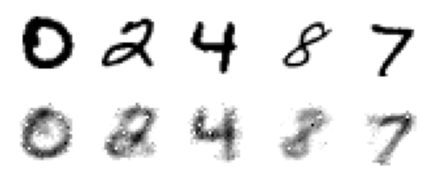

In [19]:
show_reconstruction(ae, 5)

# Denoising Autoencoder

In [52]:
encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(28,28,1)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(500, activation="relu"),
    keras.layers.Dense(400, activation="relu"),
])
decoder = keras.models.Sequential([
    keras.layers.Dense(500, input_shape=[400], activation="relu"),
    keras.layers.Dense(28*28, activation="relu"),
    keras.layers.Reshape((28,28,1))
])

denoising_ae = keras.models.Sequential([encoder, decoder])

In [53]:
denoising_ae.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(1e-3))
denoising_ae.fit(train_no_labels, epochs=6)

Epoch 1/6
469/469 [==============================] - 17s 36ms/step - loss: 0.3002
Epoch 2/6
469/469 [==============================] - 16s 35ms/step - loss: 0.2556
Epoch 3/6
469/469 [==============================] - 20s 42ms/step - loss: 0.2372
Epoch 4/6
469/469 [==============================] - 22s 47ms/step - loss: 0.2400
Epoch 5/6
469/469 [==============================] - 16s 35ms/step - loss: 0.2342
Epoch 6/6
469/469 [==============================] - 16s 35ms/step - loss: 0.2228


In [54]:
def show_reconstruction_denoised(model, n_images):
    #reconstructions = model.predict(test.take(n_images))
    fig = plt.figure(figsize=(n_images*1.5, 3))
    for img_index, example in enumerate(test.take(n_images)):
        img = example[0]
        img = tf.nn.dropout(img, 0.5)
        reconstruction = model.predict(img)
        plt.subplot(2, n_images, 1 + img_index)
        plot_image(img[0])
        plt.subplot(2, n_images, 1 + img_index + n_images)
        plot_image(reconstruction[0])

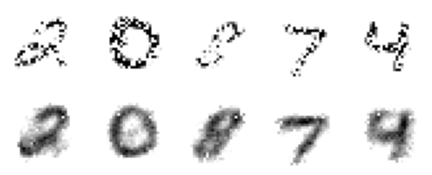

In [55]:
show_reconstruction_denoised(denoising_ae, 5)

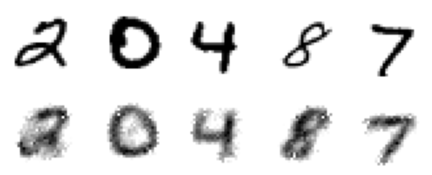

In [56]:
show_reconstruction(denoising_ae, 5)

# Convolutional Autoencoder

In [66]:
conv_encoder = keras.models.Sequential([
    keras.layers.Conv2D(16, kernel_size=3, padding="same", activation='relu', input_shape(28,28,1)),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding='same', activation='relu'),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding='same', activation='relu'),
    keras.layers.MaxPool2D(pool_size=2),
])
conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding='valid', activation='relu', input_shape=[3,3,64]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding='same', activation='relu'),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding='same', activation='relu'),
])

conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

SyntaxError: positional argument follows keyword argument (<ipython-input-66-1258dbf53953>, line 2)

In [73]:
conv_ae.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(1e-3))
conv_ae.fit(train_no_labels, epochs=6)

Epoch 1/6
469/469 [==============================] - 56s 119ms/step - loss: 0.2394
Epoch 2/6
469/469 [==============================] - 51s 110ms/step - loss: 0.1536
Epoch 3/6
469/469 [==============================] - 52s 110ms/step - loss: 0.1466
Epoch 4/6
469/469 [==============================] - 55s 116ms/step - loss: 0.1441
Epoch 5/6
469/469 [==============================] - 51s 109ms/step - loss: 0.1292
Epoch 6/6
469/469 [==============================] - 52s 111ms/step - loss: 0.1236


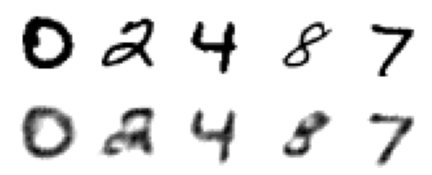

In [74]:
show_reconstruction(conv_ae, 5)

In [75]:
conv_ae.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_14 (Sequential)   (None, 3, 3, 64)          23296     
_________________________________________________________________
sequential_15 (Sequential)   (None, 28, 28, 1)         23233     
Total params: 46,529
Trainable params: 46,529
Non-trainable params: 0
_________________________________________________________________


In [77]:
ae.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 100)               113380    
_________________________________________________________________
sequential_2 (Sequential)    (None, 28, 28, 1)         114064    
Total params: 227,444
Trainable params: 227,444
Non-trainable params: 0
_________________________________________________________________


## Hyperparam Tuning (Loss Function, activation, and regularization)

In [80]:
def recon_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_pred - y_true))

In [81]:
l2_reg = 0.0001
l2_regularizer = keras.regularizers.l2(l2_reg)

encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(28,28,1)),
    keras.layers.Dense(300, activation="elu", kernel_initializer='he_normal', kernel_regularizer=l2_regularizer),
    keras.layers.Dense(150, activation="elu", kernel_initializer='he_normal', kernel_regularizer=l2_regularizer),
])
decoder = keras.models.Sequential([
    keras.layers.Dense(300, input_shape=[150], activation="elu", kernel_initializer='he_normal', kernel_regularizer=l2_regularizer),
    keras.layers.Dense(28*28, activation='elu', kernel_initializer='he_normal', kernel_regularizer=l2_regularizer),
    keras.layers.Reshape((28,28,1))
])

ae = keras.models.Sequential([encoder, decoder])

In [83]:
ae.compile(loss=recon_loss, optimizer=keras.optimizers.Adam(1e-2))
ae.fit(train_no_labels, epochs=5)

Epoch 1/5
469/469 [==============================] - 10s 22ms/step - loss: 0.1630
Epoch 2/5
469/469 [==============================] - 10s 22ms/step - loss: 0.0366
Epoch 3/5
469/469 [==============================] - 10s 22ms/step - loss: 0.0319
Epoch 4/5
469/469 [==============================] - 10s 21ms/step - loss: 0.0318
Epoch 5/5
469/469 [==============================] - 10s 21ms/step - loss: 0.0321


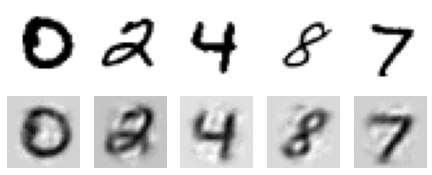

In [84]:
show_reconstruction(ae, 5)

Epoch 1/5
469/469 [==============================] - 11s 23ms/step - loss: 1.5277
Epoch 2/5
469/469 [==============================] - 11s 24ms/step - loss: 1.8355
Epoch 3/5
469/469 [==============================] - 11s 24ms/step - loss: 1.9296
Epoch 4/5
469/469 [==============================] - 11s 23ms/step - loss: 1.8805
Epoch 5/5
469/469 [==============================] - 11s 23ms/step - loss: 1.9651


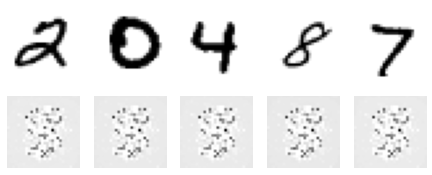

In [87]:
ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(1e-3))
ae.fit(train_no_labels, epochs=5)
show_reconstruction(ae, 5)

Epoch 1/5
469/469 [==============================] - 11s 23ms/step - loss: 0.0787
Epoch 2/5
469/469 [==============================] - 10s 22ms/step - loss: 0.0402
Epoch 3/5
469/469 [==============================] - 10s 22ms/step - loss: 0.0354
Epoch 4/5
469/469 [==============================] - 10s 22ms/step - loss: 0.0338
Epoch 5/5
469/469 [==============================] - 11s 23ms/step - loss: 0.0331


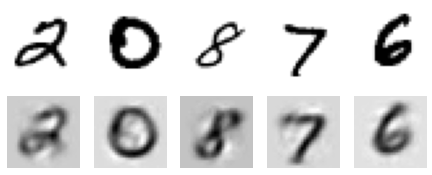

In [88]:
ae.compile(loss="mse", optimizer=keras.optimizers.Adam(1e-3))
ae.fit(train_no_labels, epochs=5)
show_reconstruction(ae, 5)

In [99]:
encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(28,28,1)),
    keras.layers.Dense(300, activation="elu"),
    keras.layers.Dense(150, activation="elu"),
])
decoder = keras.models.Sequential([
    keras.layers.Dense(300, input_shape=[150], activation="elu"),
    keras.layers.Dense(28*28, activation='elu'),
    keras.layers.Reshape((28,28,1))
])

ae_elu = keras.models.Sequential([encoder, decoder])

Epoch 1/5
469/469 [==============================] - 10s 21ms/step - loss: 0.3233
Epoch 2/5
469/469 [==============================] - 11s 24ms/step - loss: 1.5754
Epoch 3/5
469/469 [==============================] - 13s 28ms/step - loss: 2.1383
Epoch 4/5
469/469 [==============================] - 11s 23ms/step - loss: 2.2462
Epoch 5/5
469/469 [==============================] - 11s 23ms/step - loss: 2.2622


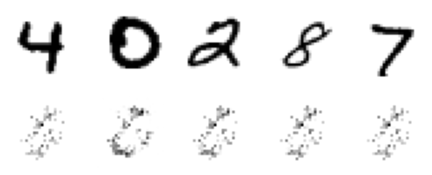

In [91]:
ae_elu.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(1e-3))
ae_elu.fit(train_no_labels, epochs=5)
show_reconstruction(ae_elu, 5)

Epoch 1/5
469/469 [==============================] - 9s 20ms/step - loss: 0.0151
Epoch 2/5
469/469 [==============================] - 10s 22ms/step - loss: 0.0052
Epoch 3/5
469/469 [==============================] - 9s 20ms/step - loss: 0.0043
Epoch 4/5
469/469 [==============================] - 9s 20ms/step - loss: 0.0040
Epoch 5/5
469/469 [==============================] - 9s 19ms/step - loss: 0.0039


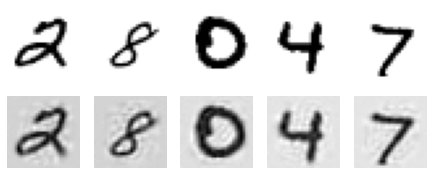

In [100]:
ae_elu.compile(loss="mse", optimizer=keras.optimizers.Adam(1e-3))
ae_elu.fit(train_no_labels, epochs=5)
show_reconstruction(ae_elu, 5)

In [102]:
encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(28,28,1)),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(150, activation="relu"),
])
decoder = keras.models.Sequential([
    keras.layers.Dense(300, input_shape=[150], activation="relu"),
    keras.layers.Dense(28*28, activation='relu'),
    keras.layers.Reshape((28,28,1))
])

ae_relu = keras.models.Sequential([encoder, decoder])

Epoch 1/5
469/469 [==============================] - 10s 21ms/step - loss: 0.3478
Epoch 2/5
469/469 [==============================] - 11s 23ms/step - loss: 0.2982
Epoch 3/5
469/469 [==============================] - 10s 22ms/step - loss: 0.2616
Epoch 4/5
469/469 [==============================] - 10s 22ms/step - loss: 0.2513
Epoch 5/5
469/469 [==============================] - 11s 23ms/step - loss: 0.2337


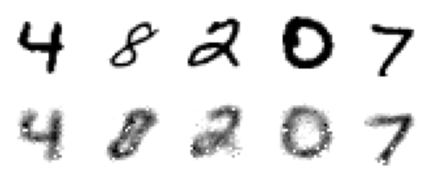

In [93]:
ae_relu.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(1e-3))
ae_relu.fit(train_no_labels, epochs=5)
show_reconstruction(ae_relu, 5)

Epoch 1/5
469/469 [==============================] - 9s 20ms/step - loss: 0.0189
Epoch 2/5
469/469 [==============================] - 9s 20ms/step - loss: 0.0095
Epoch 3/5
469/469 [==============================] - 9s 19ms/step - loss: 0.0084
Epoch 4/5
469/469 [==============================] - 9s 19ms/step - loss: 0.0079
Epoch 5/5
469/469 [==============================] - 10s 20ms/step - loss: 0.0075


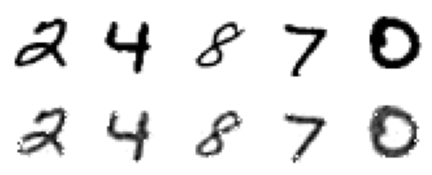

In [103]:
ae_relu.compile(loss="mse", optimizer=keras.optimizers.Adam(1e-3))
ae_relu.fit(train_no_labels, epochs=5)
show_reconstruction(ae_relu, 5)

### I observe something very strange -- with RELU activation, binary_crossentropy causes loss to go down, but with ELU activation, loss goes up, and the results are bad. MSE loss, however, makes the loss go down for ELU (and for RELU too), and results in a significantly more superior model than binary_crossentropy. Perhaps the reason why ELU and binary_crossentropy(log loss) don't work is because log(x <= 0) is undefined, and ELU allows for values <= 0

[[[0.]
  [0.]
  [0.]
  [0.]
  [0.]]]
Min Value using relu =  0.0 

[[[-0.01037174]
  [ 0.00207926]
  [-0.00019723]
  [-0.01202583]
  [-0.00254935]]]
Min Value using elu =  -0.24842626


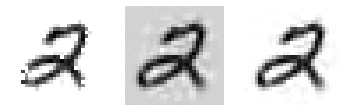

In [120]:
for img_index, example in enumerate(test.take(1)):
        img = example[0]
        reconstruction_relu = ae_relu.predict(img)
        plt.figure()
        plt.subplot(1,3,1)
        plt.imshow(reconstruction_relu[0], cmap='binary')
        plt.axis('off')
        print(reconstruction_relu[0,:1,:5])
        print("Min Value using relu = ", reconstruction_relu.min(), "\n")
        reconstruction_elu = ae_elu.predict(img)
        plt.subplot(1,3,2)
        plt.imshow(reconstruction_elu[0], cmap='binary')
        plt.axis('off')
        print(reconstruction_elu[0,:1,:5])
        print("Min Value using elu = ", reconstruction_elu.min())

        reconstruction_elu_rectified = tf.where(reconstruction_elu < 0,
                                               tf.zeros_like(reconstruction_elu),
                                               reconstruction_elu)
        plt.subplot(1,3,3)
        plt.imshow(reconstruction_elu_rectified[0], cmap='binary')
        plt.axis('off')

        

### This also explains why we observe the fuzzy area around the digits with ELU, and we don't with RELU -- relu produces 0s, while ELU produces some negative digits